In [2]:
#imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import nltk

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allisonbaun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/allisonbaun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allisonbaun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:

df = pd.read_csv('fake_job_postings.csv')

#Extract features
features = df.columns[:-1] 


#Count the non-null occurrences per feature, split by fraudulent and non-fraudulent
non_null_counts = pd.DataFrame({
   feature: df.groupby("fraudulent")[feature].apply(lambda x: x.notnull().sum())
   for feature in features
}).T.rename(columns={0: "Non-Fraudulent", 1: "Fraudulent"})



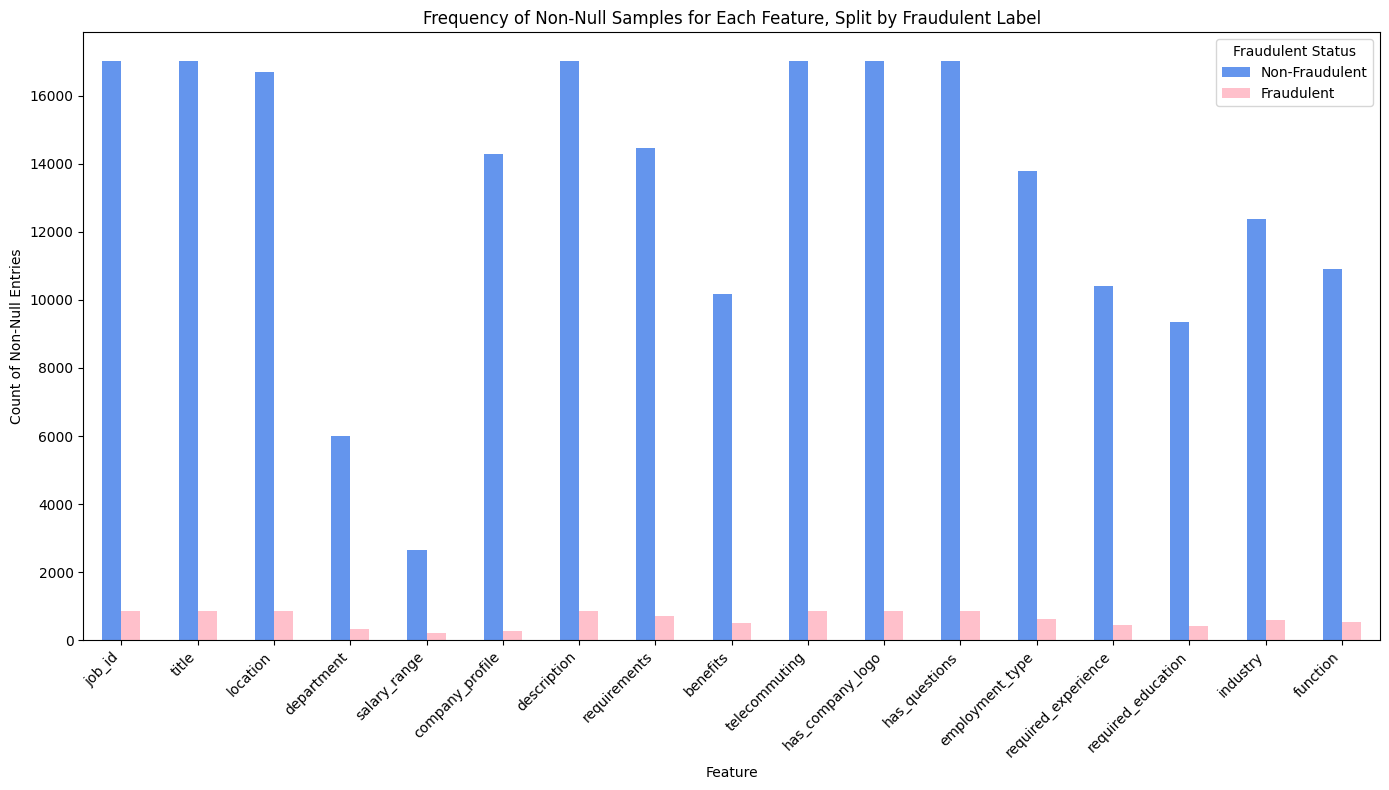

In [ ]:

#Plotting dist.
non_null_counts.plot(kind="bar", stacked=False, figsize=(14, 8), color=["cornflowerblue", "pink"])
plt.title("Frequency of Non-Null Samples for Each Feature, Split by Fraudulent Label")
plt.xlabel("Feature")
plt.ylabel("Count of Non-Null Entries")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Fraudulent Status")
plt.tight_layout()
plt.show()

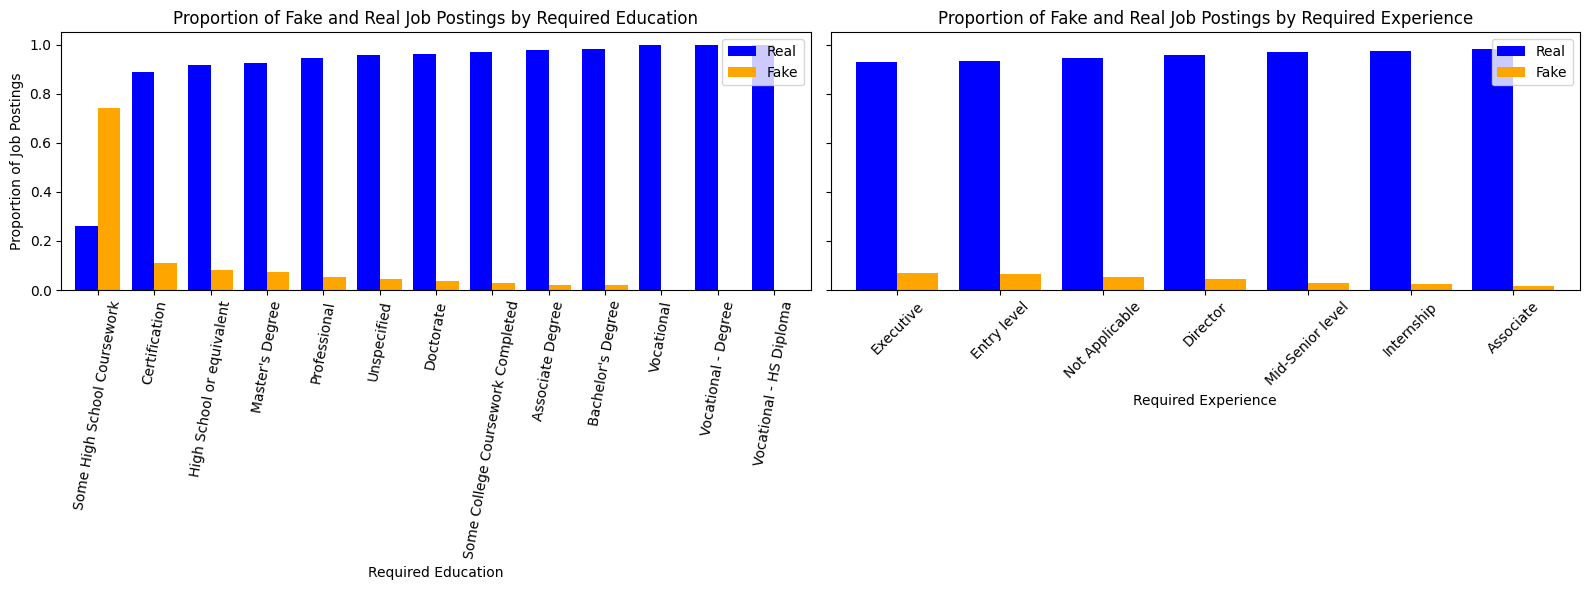

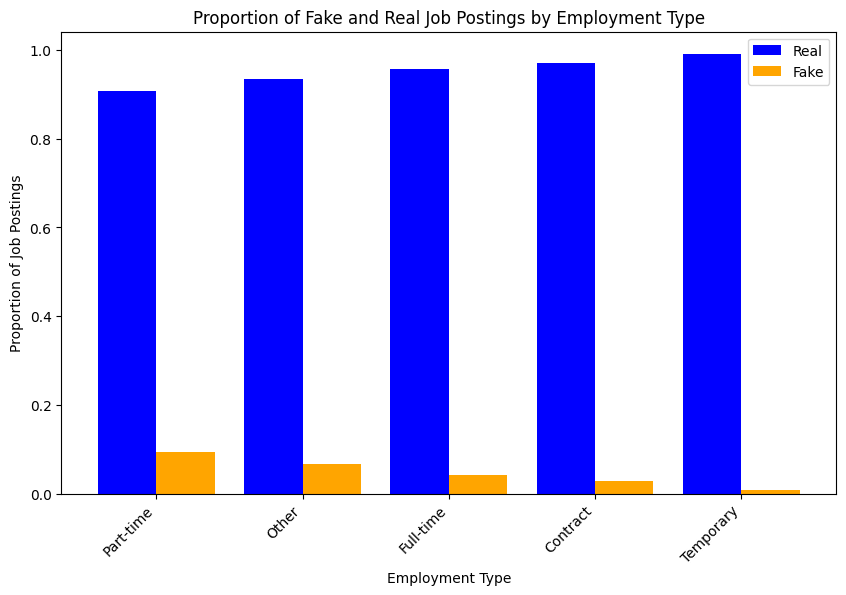

In [5]:
#required experience 

fake_proportions = (df[df['fraudulent'] == 1]
                    .groupby('required_experience')
                    .size()
                    / df.groupby('required_experience').size())

# Sort by proportion of fraudulent postings
sorted_experience = fake_proportions.sort_values(ascending=False).index

# Re-index the grouped data to match the sorted order
fake_required_experience = (df.groupby(['required_experience', 'fraudulent'])
                            .size()
                            .unstack(fill_value=0))
fake_required_experience = fake_required_experience.div(fake_required_experience.sum(axis=1), axis=0)
fake_required_experience = fake_required_experience.reindex(sorted_experience)



#proportion based off of required education 
# Calculate proportions of fake job postings
fake_proportions2 = (df[df['fraudulent'] == 1]
                    .groupby('required_education')
                    .size()
                    / df.groupby('required_education').size())

# Sort by proportion of fraudulent postings
sorted_education = fake_proportions2.sort_values(ascending=False).index

# Re-index the grouped data to match the sorted order
fake_required_education = (df.groupby(['required_education', 'fraudulent'])
                            .size()
                            .unstack(fill_value=0))
fake_required_education = fake_required_education.div(fake_required_education.sum(axis=1), axis=0)
fake_required_education = fake_required_education.reindex(sorted_education)





fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for required education
fake_required_education.plot(kind='bar', ax=axes[0], color=['blue', 'orange'], width=0.8)
axes[0].set_title('Proportion of Fake and Real Job Postings by Required Education')
axes[0].set_xlabel('Required Education')
axes[0].set_ylabel('Proportion of Job Postings')
axes[0].tick_params(axis='x', rotation=80)
axes[0].legend(['Real', 'Fake'])

# Plot for employment type
fake_required_experience.plot(kind='bar', ax=axes[1], color=['blue', 'orange'], width=0.8)
axes[1].set_title('Proportion of Fake and Real Job Postings by Required Experience')
axes[1].set_xlabel('Required Experience')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(['Real', 'Fake'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()




#required employment type  

fake_proportions = (df[df['fraudulent'] == 1]
                    .groupby('employment_type')
                    .size()
                    / df.groupby('employment_type').size())

# Sort by proportion of fraudulent postings
sorted_employment_type = fake_proportions.sort_values(ascending=False).index

# Re-index the grouped data to match the sorted order
fake_employment_type = (df.groupby(['employment_type', 'fraudulent'])
                            .size()
                            .unstack(fill_value=0))
fake_employment_type = fake_employment_type.div(fake_employment_type.sum(axis=1), axis=0)
fake_employment_type = fake_employment_type.reindex(sorted_employment_type)

# Plotting
fake_employment_type.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'], width=0.8)
plt.title('Proportion of Fake and Real Job Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Proportion of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.legend(['Real', 'Fake'])
plt.show()


In [ ]:
#Cleaning columns that arent being used in analysis
df_dropped = df.drop(columns=['salary_range','has_questions'])

count_loc = df_dropped.location.value_counts()
print(count_loc)

#Only focus on US daata
df_US = df_dropped[df_dropped['location'].str.contains('US', na=False)]

df_US.loc[df_US['benefits'] == 'See job description', 'benefits'] = 'Unspecified'

df_US.replace('', 'Unspecified', inplace=True)

df_US.fillna('Unspecified', inplace=True)

stop_words = set(stopwords.words('english'))

location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
                        ... 
GB, SFK, Leiston           1
GB, LND, Hammersmith       1
US, WA, Seattle            1
BE                         1
GB, WSX, Chichester        1
Name: count, Length: 3105, dtype: int64


/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/1121844453.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US.replace('', 'Unspecified', inplace=True)
/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/1121844453.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US.fillna('Unspecified', inplace=True)


In [28]:
#Feature Engineering for character and word count

# Create a new DataFrame with text lengths in characters and words
df_lengths = df_US[['fraudulent']].copy()  # Maintain the 'fraudulent' column

# Add character length columns
df_lengths['company_profile_length'] = df_US['company_profile'].apply(len)
df_lengths['description_length'] = df_US['description'].apply(len)
df_lengths['requirements_length'] = df_US['requirements'].apply(len)
df_lengths['benefits_length'] = df_US['benefits'].apply(len)

# Add word count columns
df_lengths['company_profile_word_count'] = df_US['company_profile'].apply(lambda x: len(x.split()))
df_lengths['description_word_count'] = df_US['description'].apply(lambda x: len(x.split()))
df_lengths['requirements_word_count'] = df_US['requirements'].apply(lambda x: len(x.split()))
df_lengths['benefits_word_count'] = df_US['benefits'].apply(lambda x: len(x.split()))

# Display the first few rows of the new DataFrame
print(df_lengths.head())

   fraudulent  company_profile_length  description_length  \
0           0                     885                 905   
2           0                     879                 355   
3           0                     614                2600   
4           0                    1628                1520   
5           0                      11                3418   

   requirements_length  benefits_length  company_profile_word_count  \
0                  852               11                         141   
2                 1363               11                         141   
3                 1429              782                          85   
4                  757               21                         207   
5                   11               11                           1   

   description_word_count  requirements_word_count  benefits_word_count  
0                     124                      115                    1  
2                      50                      164        

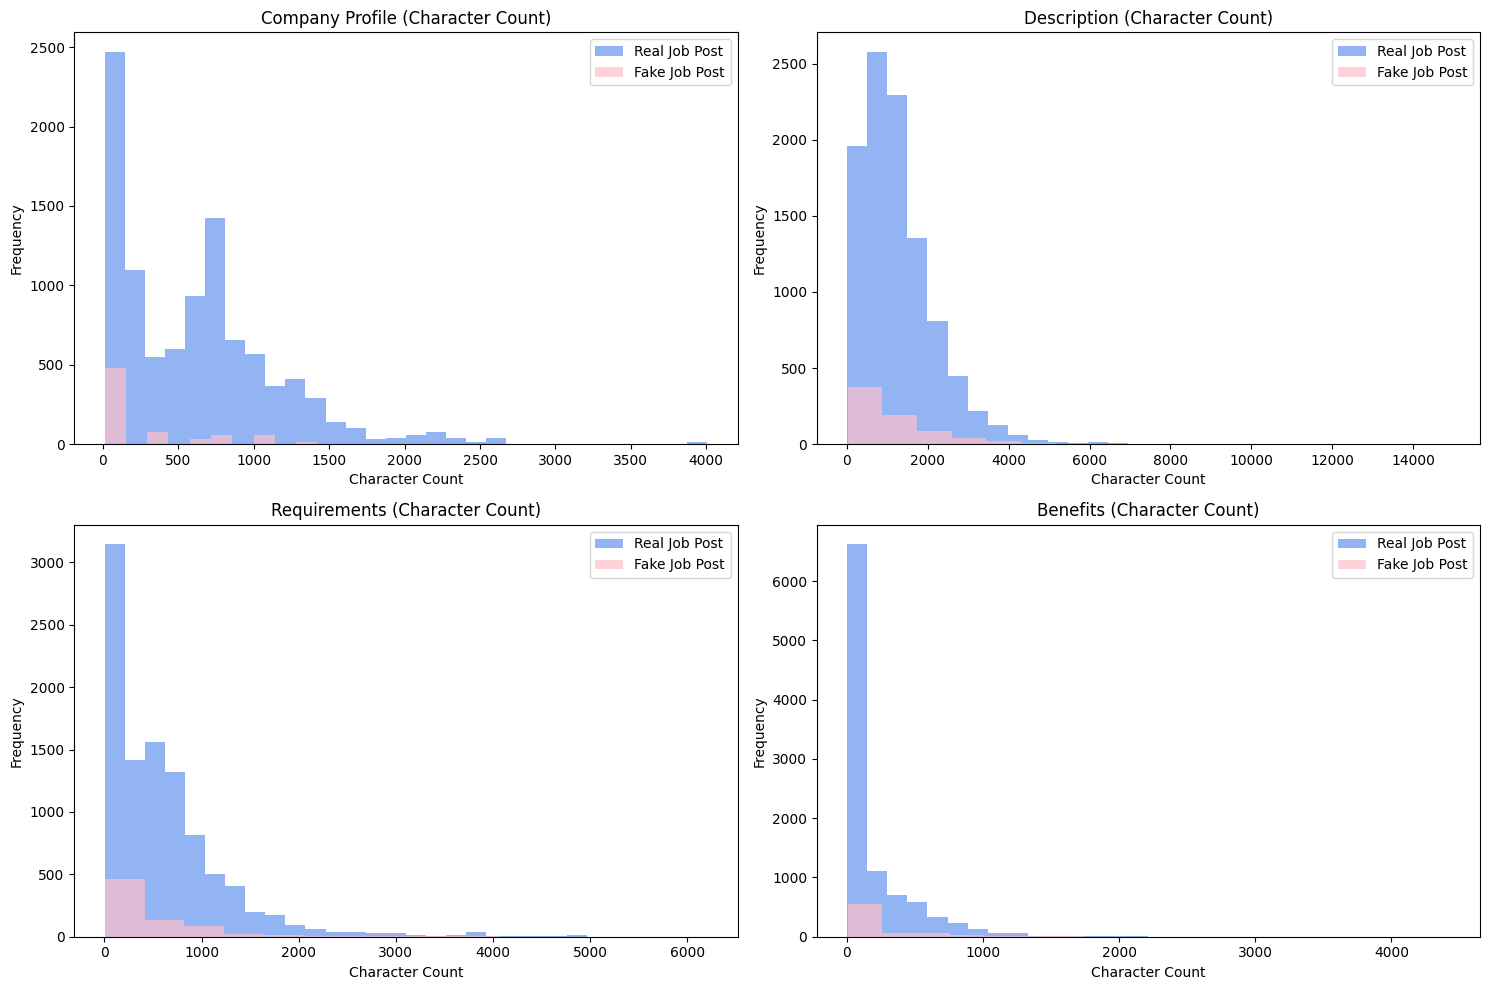

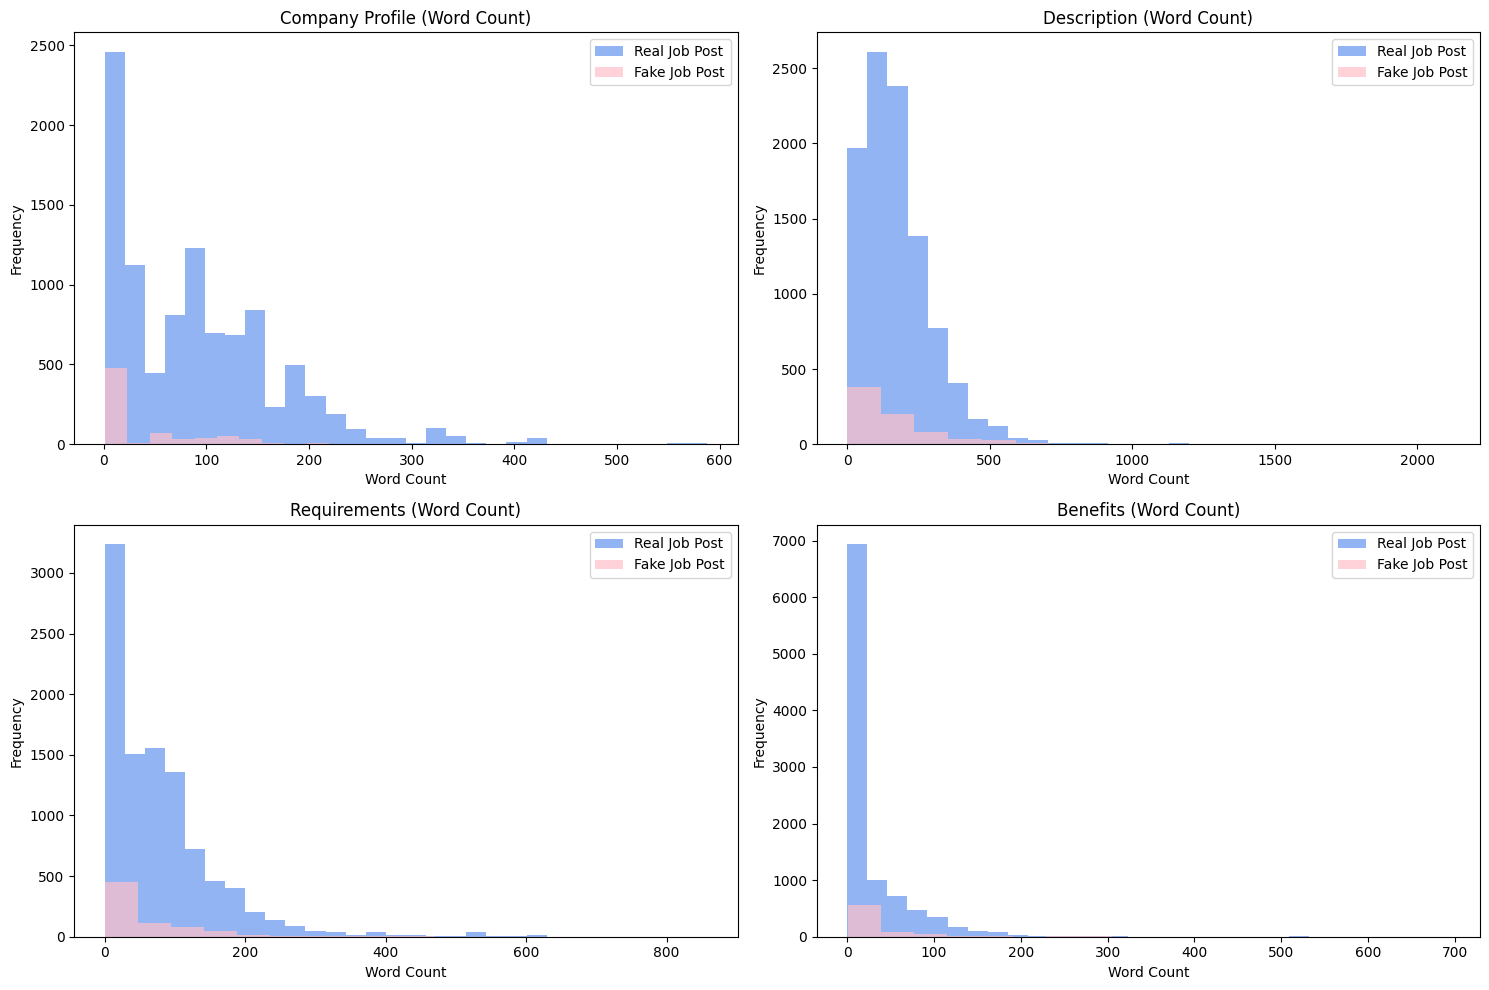

In [29]:
#Data for plotting
fields = ['company_profile', 'description', 'requirements', 'benefits']
char_lengths = [f"{field}_length" for field in fields]
word_counts = [f"{field}_word_count" for field in fields]
titles = ['Company Profile', 'Description', 'Requirements', 'Benefits']

#Plot character length frequencies
fig1, axes1 = plt.subplots(2, 2, figsize=(15, 10)) 
axes1 = axes1.ravel()

for i, field in enumerate(char_lengths):
    ax = axes1[i]
    df_lengths[df_lengths['fraudulent'] == 0][field].plot(
        bins=30, kind='hist', color='cornflowerblue', label='Real Job Post', alpha=0.7, ax=ax
    )
    df_lengths[df_lengths['fraudulent'] == 1][field].plot(
        kind='hist', color='pink', label='Fake Job Post', alpha=0.7, ax=ax
    )
    ax.set_title(f"{titles[i]} (Character Count)")
    ax.set_xlabel("Character Count")
    ax.legend()

plt.tight_layout()
plt.show()

#Plot word count frequencies
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 10))  
axes2 = axes2.ravel()

for i, field in enumerate(word_counts):
    ax = axes2[i]
    df_lengths[df_lengths['fraudulent'] == 0][field].plot(
        bins=30, kind='hist', color='cornflowerblue', label='Real Job Post', alpha=0.7, ax=ax
    )
    df_lengths[df_lengths['fraudulent'] == 1][field].plot(
        kind='hist', color='pink', label='Fake Job Post', alpha=0.7, ax=ax
    )
    ax.set_title(f"{titles[i]} (Word Count)")
    ax.set_xlabel("Word Count")
    ax.legend()

plt.tight_layout()
plt.show()


In [30]:
import re

stop_words = set(stopwords.words('english'))  
lemmatizer = WordNetLemmatizer() 

def preprocess_text(x):
    if pd.isnull(x) or x == 'nan':
        return "not specified"
    x = str(x)
    x = x.lower()
    #Remove URLs, emails, phone numbers, and links
    x = re.sub(r"(#url_.*#)|(#email.*#)|(#phone.*#)|((http|https)://\S+)|(&\w+;)|(&amp;)", ' ', x)
    x = re.sub(r'\b(?!a\b)\w{1}\b', '', x)
    x = re.sub(r'\s+', ' ', x).strip()
    #Tokenize and filter
    tokens = re.findall(r"[\w']+", x)
    tokens = [word for word in tokens if ((word not in stop_words) and (len(word) > 1) and not word.isdigit()) and word != 'unspecified']
    #Lemmatize tokens
    lemmatized_tokens = list(map(lemmatizer.lemmatize, tokens))
    #Join back into a single string
    return ' '.join(lemmatized_tokens)


text_preprocess = ['title', 'company_profile', 'description', 'requirements', 'benefits']
for field in text_preprocess:
    df_US[f'{field}_cleaned'] = df_US[field].apply(lambda x: preprocess_text(x))

/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/754283469.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US[f'{field}_cleaned'] = df_US[field].apply(lambda x: preprocess_text(x))
/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/754283469.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US[f'{field}_cleaned'] = df_US[field].apply(lambda x: preprocess_text(x))
/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/754283469.py:26: SettingWithCopyWarni

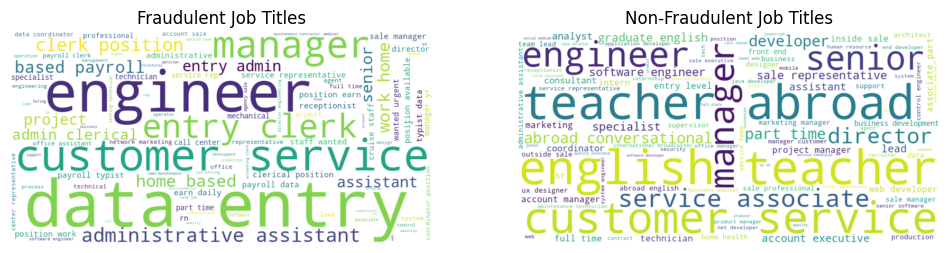

In [33]:
title_vis_fraudulent = " ".join(title for title in df_US[df_US['fraudulent'] == 1]['title_cleaned'] if title != "unspecified")
title_vis_non_fraudulent = " ".join(title for title in df_US[df_US['fraudulent'] == 0]['title_cleaned'] if title != "unspecified")


wordcloud_title_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(title_vis_fraudulent)
wordcloud_title_non_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(title_vis_non_fraudulent)

# Create subplots for the two word clouds
plt.figure(figsize=(12, 6))

# Description
plt.subplot(1,2,1)
plt.imshow(wordcloud_title_fraudulent, interpolation='bilinear')
plt.title("Fraudulent Job Titles")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_title_non_fraudulent, interpolation='bilinear')
plt.title("Non-Fraudulent Job Titles")
plt.axis("off")

# Display the plot
plt.show()

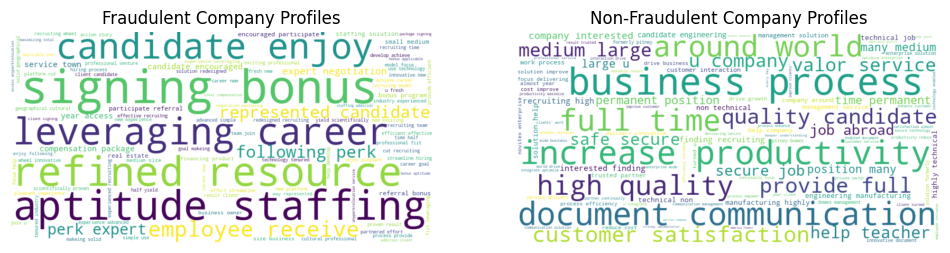

In [34]:

# Separate data for fraudulent vs non-fraudulent postings
company_vis_fraudulent = " ".join(company for company in df_US[df_US['fraudulent'] == 1]['company_profile_cleaned'] if company != "unspecified")
company_vis_non_fraudulent = " ".join(company for company in df_US[df_US['fraudulent'] == 0]['company_profile_cleaned'] if company != "unspecified")

# Generate word clouds for both categories
wordcloud_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(company_vis_fraudulent)
wordcloud_non_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(company_vis_non_fraudulent)

# Create subplots for the two word clouds
plt.figure(figsize=(12, 6))

# Plot for fraudulent job postings
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(wordcloud_fraudulent, interpolation='bilinear')
plt.title("Fraudulent Company Profiles")
plt.axis("off")

# Plot for non-fraudulent job postings
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(wordcloud_non_fraudulent, interpolation='bilinear')
plt.title("Non-Fraudulent Company Profiles")
plt.axis("off")

# Display the plot
plt.show()

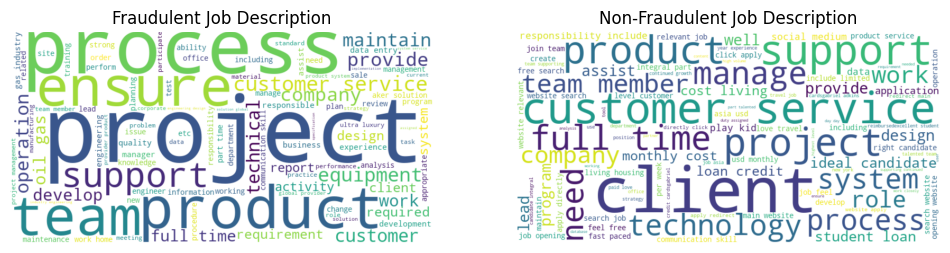

In [35]:

description_vis_fraudulent = " ".join(description for description in df_US[df_US['fraudulent'] == 1]['description_cleaned'] if description != "unspecified")
description_vis_non_fraudulent = " ".join(description for description in df_US[df_US['fraudulent'] == 0]['description_cleaned'] if description != "unspecified")


wordcloud_description_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(description_vis_fraudulent)
wordcloud_description_non_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(description_vis_non_fraudulent)

# Create subplots for the two word clouds
plt.figure(figsize=(12, 6))

# Description
plt.subplot(1,2,1)
plt.imshow(wordcloud_description_fraudulent, interpolation='bilinear')
plt.title("Fraudulent Job Description")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_description_non_fraudulent, interpolation='bilinear')
plt.title("Non-Fraudulent Job Description")
plt.axis("off")

# Display the plot
plt.show()


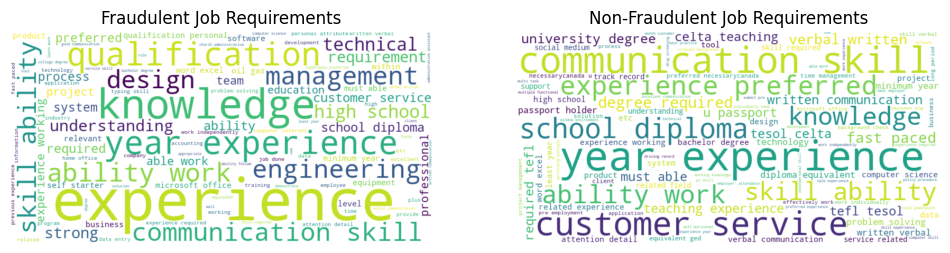

In [36]:

requirements_vis_fraudulent = " ".join(requirement for requirement in df_US[df_US['fraudulent'] == 1]['requirements_cleaned'] if requirement != "unspecified")
requirements_vis_non_fraudulent = " ".join(requirement for requirement in df_US[df_US['fraudulent'] == 0]['requirements_cleaned'] if requirement != "unspecified")

wordcloud_requirements_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(requirements_vis_fraudulent)
wordcloud_requirements_non_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(requirements_vis_non_fraudulent)

plt.figure(figsize=(12,6))

# Description
plt.subplot(1,2,1)
plt.imshow(wordcloud_requirements_fraudulent, interpolation='bilinear')
plt.title("Fraudulent Job Requirements")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_requirements_non_fraudulent, interpolation='bilinear')
plt.title("Non-Fraudulent Job Requirements")
plt.axis("off")



plt.show()

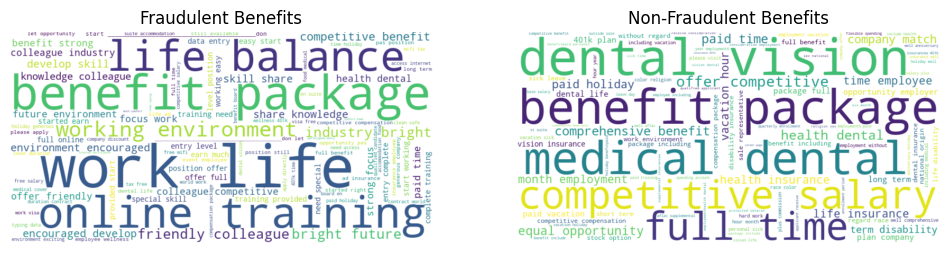

In [37]:
benefits_vis_fraudulent = " ".join(benefit for benefit in df_US[df_US['fraudulent'] == 1]['benefits_cleaned'] if benefit != "unspecified")
benefits_vis_non_fraudulent = " ".join(benefit for benefit in df_US[df_US['fraudulent'] == 0]['benefits_cleaned'] if benefit != "unspecified")


wordcloud_benefits_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(benefits_vis_fraudulent)
wordcloud_benefits_non_fraudulent = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(benefits_vis_non_fraudulent)


plt.figure(figsize=(12,6))

# Description
plt.subplot(1,2,1)
plt.imshow(wordcloud_benefits_fraudulent, interpolation='bilinear')
plt.title("Fraudulent Benefits")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_benefits_non_fraudulent, interpolation='bilinear')
plt.title("Non-Fraudulent Benefits")
plt.axis("off")

plt.show()

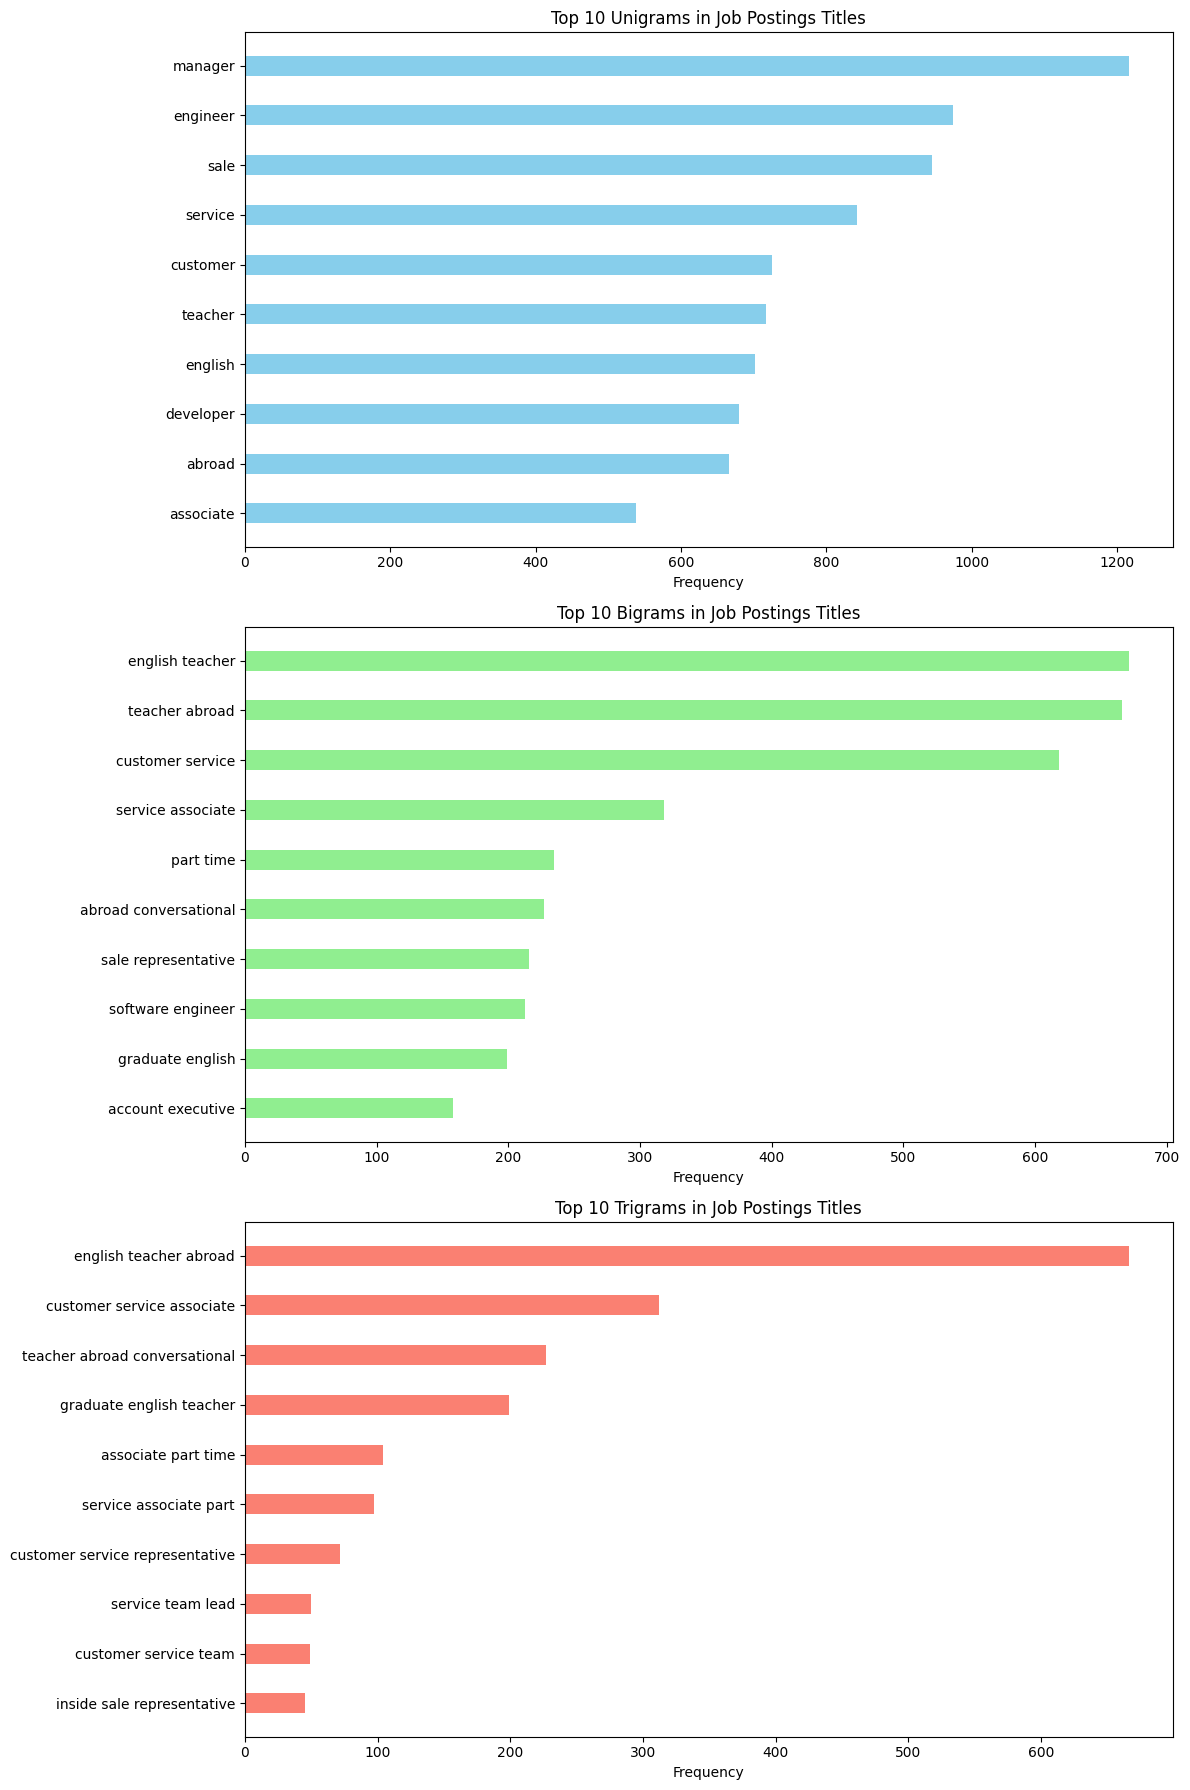

In [38]:


def get_top_ngrams(text_data, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_counts = vectorizer.fit_transform(text_data)
    ngram_counts_sum = ngram_counts.sum(axis=0)
    
    # Get n-grams and their counts
    ngrams = [(ngram, ngram_counts_sum[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    sorted_ngrams = sorted(ngrams, key=lambda x: x[1], reverse=True)[:top_k]
    
    ngrams, counts = zip(*sorted_ngrams)
    return ngrams, counts

top_unigrams, unigram_counts = get_top_ngrams(df_US['title_cleaned'], n=1, top_k=10)
top_bigrams, bigram_counts = get_top_ngrams(df_US['title_cleaned'], n=2, top_k=10)
top_trigrams, trigram_counts = get_top_ngrams(df_US['title_cleaned'], n=3, top_k=10)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot the unigrams
axes[0].barh(top_unigrams, unigram_counts, color='skyblue',height=0.4)
axes[0].set_xlabel("Frequency")
axes[0].set_title("Top 10 Unigrams in Job Postings Titles")
axes[0].invert_yaxis()

# Plot the bigrams
axes[1].barh(top_bigrams, bigram_counts, color='lightgreen',height=0.4)
axes[1].set_xlabel("Frequency")
axes[1].set_title("Top 10 Bigrams in Job Postings Titles")
axes[1].invert_yaxis()

# Plot the trigrams
axes[2].barh(top_trigrams, trigram_counts, color='salmon',height=0.4)
axes[2].set_xlabel("Frequency")
axes[2].set_title("Top 10 Trigrams in Job Postings Titles")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
#pre-processing for the tf-dif

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

In [35]:
# use df_US to create logistic linear regression using TF-IDF
# helpful: https://github.com/arqylabs/spam_classifier_tf-idf/blob/master/spam_classifier.ipynb
# other doc poential: https://medium.com/swlh/text-classification-using-tf-idf-7404e75565b8

In [40]:
df_US['full_text'] = df_US['title'].astype(str) + ' ' + df_US['company_profile'].astype(str) + ' ' + df_US['description'].astype(str) + ' ' + df_US['requirements'].astype(str) + ' ' + df_US['benefits'].astype(str)

/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/3530971224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US['full_text'] = df_US['title'].astype(str) + ' ' + df_US['company_profile'].astype(str) + ' ' + df_US['description'].astype(str) + ' ' + df_US['requirements'].astype(str) + ' ' + df_US['benefits'].astype(str)


In [41]:
# Initialize TF-IDF Vectorizer for single words

df_US['full_text'] = df_US['full_text'].apply(preprocess_text)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1)) 

#Apply TF-IDF on the 'full_text' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df_US['full_text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/1525946606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_US['full_text'] = df_US['full_text'].apply(preprocess_text)


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC


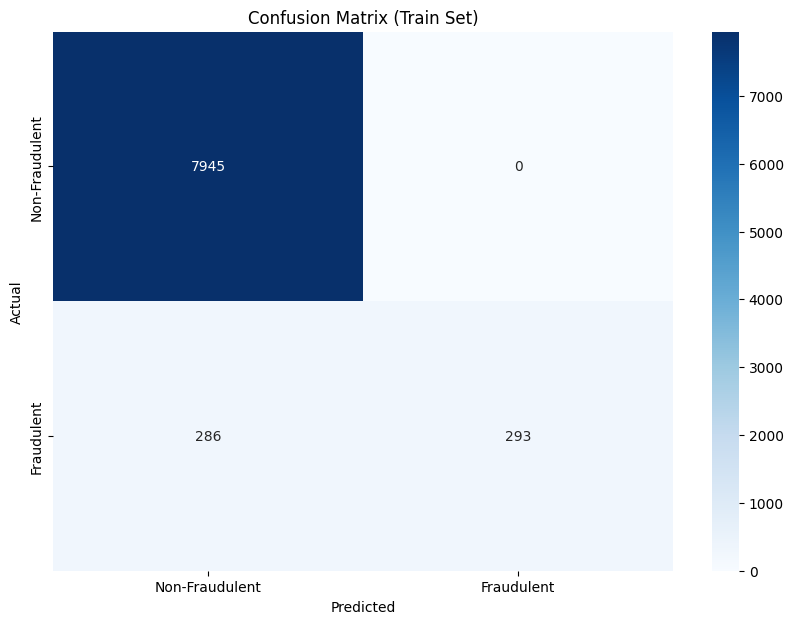

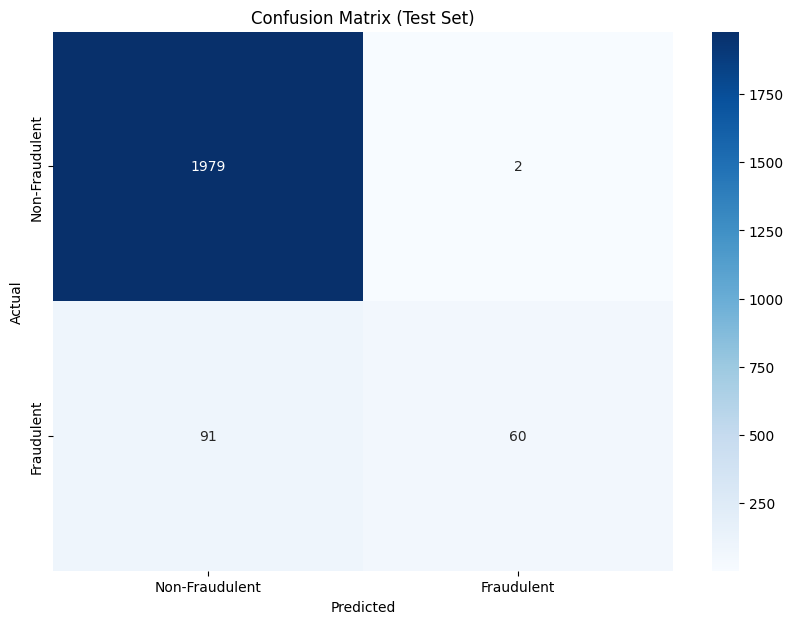

In [44]:
#Logistic Regression
X = tfidf_matrix
y = df_US['fraudulent']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model and prediction
model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#Confusion matrices
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

#Plot 
plt.figure(figsize=(10, 7))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraudulent', 'Fraudulent'], 
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Confusion Matrix (Train Set)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraudulent', 'Fraudulent'], 
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [45]:
from sklearn.metrics import accuracy_score, recall_score

# Calculate accuracy for the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate recall for the testing set
test_recall = recall_score(y_test, y_test_pred)

# Print the results
print(f"Test Set Accuracy: {test_accuracy:.2f}")
print(f"Test Set Recall: {test_recall:.2f}")

Test Set Accuracy: 0.96
Test Set Recall: 0.40


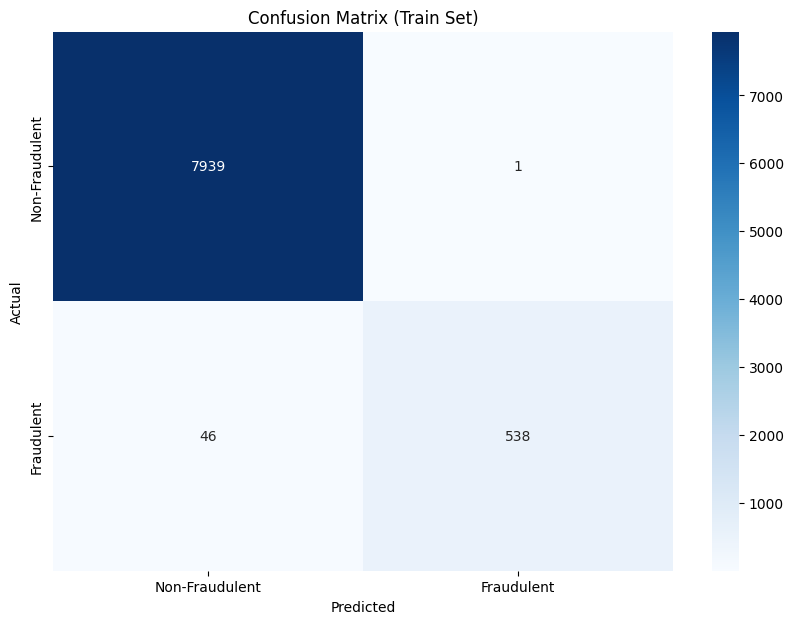

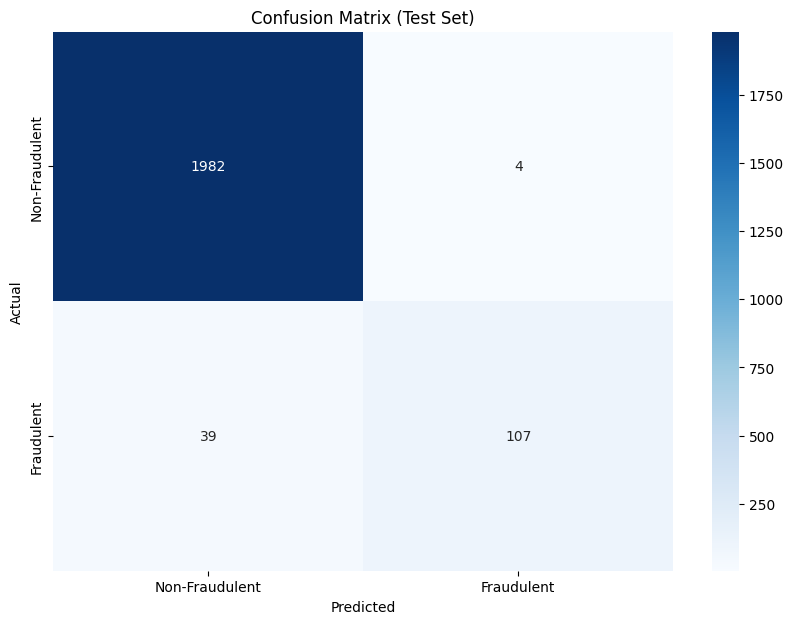

In [46]:
#SVM
X = tfidf_matrix
y = df_US['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)

svm_model.fit(X_train, y_train)

y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraudulent', 'Fraudulent'], 
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Confusion Matrix (Train Set)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraudulent', 'Fraudulent'], 
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [47]:
test_accuracy = accuracy_score(y_test, y_test_pred)

test_recall = recall_score(y_test, y_test_pred)

print(f"Test Set Accuracy: {test_accuracy:.2f}")
print(f"Test Set Recall: {test_recall:.2f}")

Test Set Accuracy: 0.98
Test Set Recall: 0.73


## stuff for doc2vec below

In [ ]:
import re

df = pd.read_csv('fake_job_postings.csv')


features = df.columns[:-1] 

df_dropped = df.drop(columns=['salary_range','has_questions'])


df_US = df_dropped[df_dropped['location'].str.contains('US', na=False)]

train_data_for_tfidf = df_US[['description', 'fraudulent']]

train_data_for_d2v = df_US[['company_profile', 'requirements', 'benefits', 'description', 'fraudulent']]
train_data_for_d2v['combined'] = train_data_for_d2v.apply(
    lambda row: f"{row['company_profile']} {row['requirements']} {row['benefits']} {row['description']}", 
    axis=1
)
train_data_for_d2v = train_data_for_d2v[['combined', 'fraudulent']]

def cleanse(dirty):
    return " ".join(re.findall("[A-Za-z]+",dirty.lower()))
                    
train_data_for_tfidf['cleansed_data'] = train_data_for_tfidf['description'].apply(cleanse)
train_data_for_d2v['cleansed'] = train_data_for_d2v['combined'].apply(cleanse)


train_data_for_tfidf.head()

/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/2268728662.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_for_d2v['combined'] = train_data_for_d2v.apply(
/var/folders/5g/4rmds5dd2nx0dglxj0_4kttw0000gn/T/ipykernel_76449/2268728662.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_for_tfidf['cleansed_data'] = train_data_for_tfidf['description'].apply(cleanse)


,description,fraudulent,cleansed_data
0,"Food52, a fast-growing, James Beard Award-winn...",0,food a fast growing james beard award winning ...
2,"Our client, located in Houston, is actively se...",0,our client located in houston is actively seek...
3,THE COMPANY: ESRI – Environmental Systems Rese...,0,the company esri environmental systems researc...
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0,job title itemization review managerlocation f...
5,Job OverviewApex is an environmental consultin...,0,job overviewapex is an environmental consultin...


In [49]:
from sklearn.model_selection import train_test_split

train_data_for_d2v['doc_names'] = ['doc' + str(i+1) for i in range(len(train_data_for_d2v))]

def tag_document(row):
    words = simple_preprocess(row['cleansed'])
    return TaggedDocument(words=words, tags=[row['doc_names']])

tagged_job_data = train_data_for_d2v.apply(tag_document, axis=1).tolist()

modelD2V = Doc2Vec(vector_size=20, min_count=2, epochs=25)
modelD2V.build_vocab(tagged_job_data)
modelD2V.train(tagged_job_data, total_examples=modelD2V.corpus_count, epochs=modelD2V.epochs)

doc_vectors = [modelD2V.dv[idx] for idx in range(len(tagged_job_data))]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, train_data_for_d2v['fraudulent'], test_size=0.2, random_state=40)
d2vRegression = LogisticRegression(class_weight='balanced')
d2vRegression.fit(X_train, y_train)

y_pred = d2vRegression.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
c_m = confusion_matrix(y_test, y_pred)

print("-----DOC2VEC with Class Weights-----")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion matrix:\n {c_m}")

-----DOC2VEC with Class Weights-----
Accuracy: 0.6819887429643527
Precision: 0.1478494623655914
Recall: 0.7142857142857143
Confusion matrix:
 [[1344  634]
 [  44  110]]


Look into this: https://scikit-learn.org/1.5/auto_examples/model_selection/plot_precision_recall.html